In [1]:
1000# Utils
import os, sys, re, time, gc, types, string, warnings, inspect,  unicodedata, unidecode

#import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import time
import pickle
import re, sys

from sklearn.metrics import accuracy_score
from IPython.display import display, Markdown, Latex

import shutil
import os

# Representation
import nltk
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD


#plt.style.use('fivethirtyeight')
from nltk.stem.snowball import SnowballStemmer

#Carga stop word
nltk.download('stopwords')
spanish_stopwords = nltk.corpus.stopwords.words('spanish')

# punkt:  módulo contiene modelos para la tokenización de textos
nltk.download('punkt')

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/root/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Parameters

In [2]:
root_path = "../"
path_data_clean = root_path + "data/clean"
path_model = root_path + 'models/'
features_path = root_path + 'data/features/'
model_name = "tfidf10000_svd1000"
path_model += model_name

delete_old_model = True
if delete_old_model:
    try:
        os.system("rm -rf "+path_model)
        os.system("mkdir "+path_model)
    except:
        print("error")

# Load Data

falta agregar data v2 y beatiful soup para limpiar html en data 2

In [3]:
dfNoticias = pd.read_pickle(path_data_clean + "/dfNoticiasCleanV2.p")
dfNoticias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 351681 entries, 0 to 367147
Data columns (total 16 columns):
Cuerpo       351681 non-null object
Fecha        351681 non-null object
Hora         351681 non-null object
ID           351681 non-null object
Resumen      350517 non-null object
Seccion_1    351681 non-null object
Seccion_2    187037 non-null object
Seccion_3    59174 non-null object
Subtema_1    255959 non-null object
Subtema_2    114189 non-null object
Subtema_3    39513 non-null object
Tema_1       349253 non-null object
Tema_2       179833 non-null object
Tema_3       57572 non-null object
Titular      351681 non-null object
Type         351680 non-null object
dtypes: object(16)
memory usage: 45.6+ MB


In [4]:
dfNoticias = pd.read_pickle(path_data_clean + "/dfNoticiasCleanV2.p")


dfNoticias = dfNoticias.sample(frac=0.1,random_state=200)


In [5]:
dfNoticias.head()

,Cuerpo,Fecha,Hora,ID,Resumen,Seccion_1,Seccion_2,Seccion_3,Subtema_1,Subtema_2,Subtema_3,Tema_1,Tema_2,Tema_3,Titular,Type
214206,"\nEste sábado, Paris Saint Germain derrotó ina...",2018-04-01,13:17,20180401132639,\nEl brasileño alcanzó 36 campeonatos gracias ...,deportes,deportes,None,internacional,None,None,futbol,fuera de juego,None,\nDani Alves se convirtió en el futbolista con...,fid_noticia
256702,\nEl suizo Stanislas Wawrinka (3° de la ATP) c...,2014-03-22,16:57,20140322165021,\nEl helvético buscará su primer título en la ...,deportes,None,None,torneos atp,None,None,tenis,None,None,\nStanislas Wawrinka debió esforzarse para pas...,fid_noticia
343437,\nEl candidato presidencial del Juntos Podemos...,2009-12-13,09:11,20091213090336,"\nEl candidato destacó a Guillermo Teillier, H...",pais,pais,None,presidenciales,jorge arrate,None,politica,politica,None,\nArrate: Varios de nuestros candidatos a parl...,fid_noticia
95178,\nLa Presidenta Michelle Bachelet presentó un ...,2015-03-19,10:08,20150319103544,"\n""Hoy debemos poner al servicio público la va...",pais,pais,pais,reformas constitucionales,transparencia,None,politica,gobierno,presidenta bachelet,\nBachelet presentó instructivo que aumenta ex...,fid_noticia
283101,\nLAN confirmó que a partir de las 08:00 horas...,2013-05-18,07:05,20130518070758,\nOperaciones comenzaron a las 08:00 horas.\nE...,pais,economia,None,aviacion,aviacion,None,transportes,empresas,None,\nLAN confirmó reanudación de sus vuelos desde...,fid_noticia


# pre procesing



In [6]:
_map = {}
_map["Cuerpo"] = []
_map["Seccion"] = []
_map["Tema"] = []
_map["Subtema"] = []

count = 0
for index, row in dfNoticias.iterrows():    
    _map["Cuerpo"].append(row["Cuerpo"]) 
    _map["Seccion"].append(row["Seccion_1"])
    _map["Tema"].append(row["Tema_1"])
    _map["Subtema"].append(row["Subtema_1"])

df = pd.DataFrame(_map)
# Elimino clase corporativo, muy pocos ejemplos
df = df[df.Seccion != "corporativo"]

    
X_untransformed = df['Cuerpo'].reset_index(drop=True)
y1 = df['Seccion'].reset_index(drop=True)
y2 = df['Tema'].reset_index(drop=True)
y3 = df['Subtema'].reset_index(drop=True)


In [7]:
secciones=y1.unique()
dic={}
for i,seccion in enumerate(secciones):
    dic[seccion]=i
labels=y1.apply(lambda x:dic[x])

# Pre Procesing

In [8]:

def normalize_text(text):
    """ Funcion de normalizacion """    
    # split into words
    text = text.lower()
    
    tokens = nltk.tokenize.word_tokenize(text,language='spanish', preserve_line=False)
 
    
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    
    # remove remaining tokens that are n<<<<<<<<<<<<<<<<<<<<<
    words = [word for word in stripped if word.isalpha()]
    
    # stop word and remove accent
    def strip_accents(s):
        return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
    stop_words = set(spanish_stopwords)
    words = [strip_accents(w) for w in words if not w in stop_words]
    #return words
    return u" ".join(words)
   





In [9]:
from joblib import Parallel, delayed
import multiprocessing

# what are your inputs, and what operation do you want to 
# perform on each input. For example...
inputs = range(10) 

def processInput(i):
    return i * i
 
num_cores = multiprocessing.cpu_count()
     
results = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)

In [10]:
type(df)

results = Parallel(n_jobs=num_cores, verbose = 1)(delayed(normalize_text)(i) for i in X_untransformed)
texts = pd.Series(results)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 9561 tasks      | elapsed:    3.3s
[Parallel(n_jobs=12)]: Done 35156 out of 35156 | elapsed:    9.7s finished


(array([2.0801e+04, 1.2014e+04, 1.8140e+03, 3.6700e+02, 1.0700e+02,
        2.8000e+01, 8.0000e+00, 5.0000e+00, 7.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000e+00, 1.30620e+02, 2.60240e+02, 3.89860e+02, 5.19480e+02,
        6.49100e+02, 7.78720e+02, 9.08340e+02, 1.03796e+03, 1.16758e+03,
        1.29720e+03, 1.42682e+03, 1.55644e+03, 1.68606e+03, 1.81568e+03,
        1.94530e+03, 2.07492e+03, 2.20454e+03, 2.33416e+03, 2.46378e+03,
        2.59340e+03, 2.723

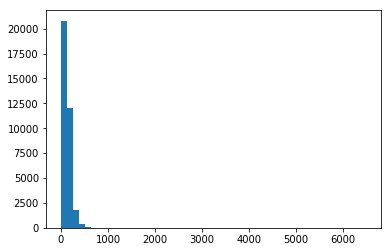

In [11]:
def count_words(text):
    return( len(text.split(" ") ) )


counts_ = []
for text in results:
    counts_.append(count_words(text) )

import matplotlib.pyplot as plt

counts = np.array(counts_)
plt.hist(counts,bins=50)

In [12]:
def cutWords(text, lim):    
    tmp = text.split(" ")
    if len(tmp) < lim:
        lim = len(tmp)
    return( u" ".join( tmp[0:lim] ) )


texts_cut = []
for text in results:
    texts_cut.append(cutWords(text,300) )

# import matplotlib.pyplot as plt

# counts = np.array(counts_)
# plt.hist(counts,bins=50)

(array([ 259., 2980., 7373., 7890., 6039., 3859., 2389., 1409.,  876.,
        2082.]),
 array([  1. ,  30.9,  60.8,  90.7, 120.6, 150.5, 180.4, 210.3, 240.2,
        270.1, 300. ]),
 <a list of 10 Patch objects>)

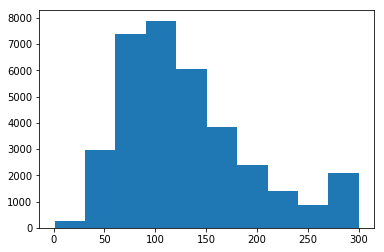

In [13]:

results_ = texts_cut

counts_ = []
for text in results_:
    counts_.append(count_words(text) )

import matplotlib.pyplot as plt

counts = np.array(counts_)
plt.hist(counts,bins=10)

In [14]:

texts = pd.Series(results_)

In [15]:
# from gensim.test.utils import common_texts, get_tmpfile
# from gensim.models import Word2Vec
# import gensim


# path = get_tmpfile("/opt/NLP_dev/models/word2vec/sbw_vectors.bin")
# word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)

# data split

In [16]:
train_fraction = 0.7

np.random.seed(42)
train_indices = np.random.choice(labels.shape[0], round(train_fraction*labels.shape[0]), replace=False)
test_indices = np.array(list(set(range(labels.shape[0])) - set(train_indices)))

texts_ = texts

X_train0 = texts.iloc[train_indices]
y_train0 = labels.iloc[train_indices]

X_test0 = texts.iloc[test_indices]
y_test0 = labels.iloc[test_indices]

### Tokenize text of the training data with keras text preprocessing functions ###

In [17]:
NUM_WORDS=133000
tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',
                      lower=True)

tokenizer.fit_on_texts(texts_)

sequences_train = tokenizer.texts_to_sequences(X_train0)
sequences_valid=tokenizer.texts_to_sequences(X_test0)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 134327 unique tokens.


In [18]:

X_train = pad_sequences(sequences_train)
X_val = pad_sequences(sequences_valid,maxlen=X_train.shape[1])
y_train = to_categorical(y_train0)
y_val = to_categorical(y_test0)
print('Shape of X train and X validation tensor:', X_train.shape,X_val.shape)
print('Shape of label train and validation tensor:', y_train.shape,y_val.shape)


Shape of X train and X validation tensor: (24609, 300) (10547, 300)
Shape of label train and validation tensor: (24609, 8) (10547, 8)


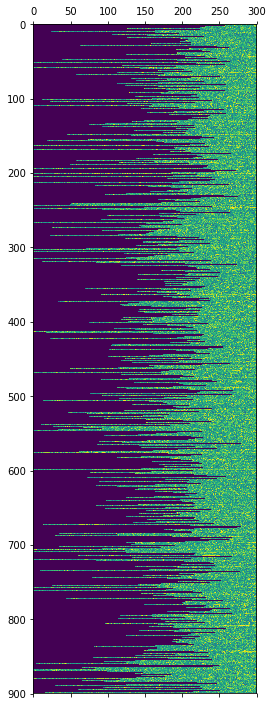

In [19]:
import matplotlib.pyplot as plt
plt.matshow(np.power(X_train[0:900],1/10))

### word embedding ###

In [20]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

#from gensim.models.keyedvectors import KeyedVectors

#word_vectors = KeyedVectors.load_word2vec_format('../GoogleNews-vectors-negative300.bin', binary=True)

word2vec_path = "/opt/NLP_dev/models/word2vec/sbw_vectors.bin"
word_vectors = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,NUM_WORDS)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)

from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=False) # TRue?

### Without pretrained data we can just initalize embedding matrixs as: ###

In [21]:
from keras.layers import Embedding
EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,NUM_WORDS)

embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            trainable=False)

# modelo

In [22]:
# from keras.layers import Dense, Input, GlobalMaxPooling1D
# from keras.layers import Conv1D, MaxPooling1D, Embedding
# from keras.models import Model
# from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,concatenate
# from keras.layers.core import Reshape, Flatten
# from keras.callbacks import EarlyStopping
# from keras.optimizers import Adam
# from keras.models import Model
# from keras import regularizers
# sequence_length = X_train.shape[1]
# filter_sizes = [3,4,5]
# num_filters = 100
# drop = 0.5



# inputs = Input(shape=(sequence_length,))
# embedding = embedding_layer(inputs)
# reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

# conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
# conv_1 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
# conv_2 = Conv2D(num_filters, (filter_sizes[2], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)

# maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)
# maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)
# maxpool_2 = MaxPooling2D((sequence_length - filter_sizes[2] + 1, 1), strides=(1,1))(conv_2)

# merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
# flatten = Flatten()(merged_tensor)
# reshape = Reshape((3*num_filters,))(flatten)
# dropout = Dropout(drop)(flatten)
# output = Dense(units=8, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)

# # this creates a model that includes
# model = Model(inputs, output)

In [23]:
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,concatenate
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import Model
from keras import regularizers
sequence_length = X_train.shape[1]
filter_sizes = [3,4,5]
num_filters = 100
drop = 0.5



inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)
reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.001))(reshape)
conv_1 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.001))(reshape)
conv_2 = Conv2D(num_filters, (filter_sizes[2], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.001))(reshape)

maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)
maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)
maxpool_2 = MaxPooling2D((sequence_length - filter_sizes[2] + 1, 1), strides=(1,1))(conv_2)

merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
flatten = Flatten()(merged_tensor)
reshape = Reshape((3*num_filters,))(flatten)
dropout = Dropout(drop)(flatten)
output = Dense(units=8, activation='softmax')(dropout)

# this creates a model that includes
model = Model(inputs, output)

In [24]:
# from keras.layers import Dense, Input, GlobalMaxPooling1D
# from keras.layers import Conv1D, MaxPooling1D, Embedding
# from keras.models import Model
# from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,concatenate
# from keras.layers.core import Reshape, Flatten
# from keras.callbacks import EarlyStopping
# from keras.optimizers import Adam
# from keras.models import Model
# from keras import regularizers

# inputs = Input(shape=(sequence_length,))

# embedded_sequences = embedding_layer(inputs)

# x = Conv1D(128, 5, activation='relu')(embedded_sequences)
# x = MaxPooling1D(5)(x)
# x = Conv1D(128, 5, activation='relu')(x)
# x = MaxPooling1D(5)(x)
# x = Conv1D(128, 5, activation='relu')(x)
# x = MaxPooling1D(35)(x)  # global max pooling
# x = Flatten()(x)
# x = Dense(128, activation='relu')(x)
# preds = Dense(8, activation='softmax')(x)

# model = Model(sequence_input, preds)
# model.compile(loss='categorical_crossentropy',
#               optimizer='rmsprop',
#               metrics=['acc'])



In [25]:
labelsSet = list(set(labels))
labelsSet.sort()
nClasses = len(labelsSet)

def calcWeights(y):
    sizes = {label: y_train0[y_train0 == label].shape[0] for label in labelsSet}
    weights = np.asarray([float(len(y_train))/(sizes[label]*nClasses) for label in y]) #n_samples / (n_classes * np.bincount(y))
    weights = np.power(weights,1) # 1.4
    return weights 

def calcWeightsL(y):
    #lerko
    scale_factor = 10e3
    sizes = {label: y_train0[y_train0 == label].shape[0] for label in labelsSet}
    weights = np.asarray([scale_factor/sizes[label] for label in y])
    return weights 

weights_train = calcWeights(y_train0)
#weights_test = calcWeights(y_test0)

weights_train

array([3.87909836, 0.96855321, 1.05890706, ..., 0.96855321, 5.58280399,
       0.35533383])

In [26]:
from sklearn.utils import class_weight

sample_weights = class_weight.compute_sample_weight('balanced', y_train)


In [27]:

from keras.callbacks import Callback
import matplotlib.pyplot as plt    
import matplotlib.patches as mpatches  
from sklearn.metrics import confusion_matrix

In [28]:
import scikitplot as skplt
import matplotlib.pyplot as plt


from keras.callbacks import Callback
import numpy as np


class ConfMat(Callback):
    def __init__(self, x, y_true, num_classes, X_val, y_val):
        super().__init__()
        
        self.x = x
        self.y_true = y_true
        self.num_classes = num_classes
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        
        y_pred=model.predict(self.x)
        
        y_val_pred_hard = []    

        for idx,val in enumerate(y_pred):
            tmp = [0]*8
            tmp[np.argmax(val)] = 1
            y_val_pred_hard.append(tmp)    

        y_true = []
        y_pred = []

        for idx,val in enumerate(y_val_pred_hard):
            y_pred.append(np.argmax(val))

        for idx,val in enumerate(self.y_true):
            y_true.append(np.argmax(val))

        

        
        skplt.metrics.plot_confusion_matrix(y_true,y_pred,normalize='True')
        plt.xticks(rotation=45)
        plt.show()
        
        
        y_pred=model.predict(self.X_val)

        y_val_pred_hard = []    

        for idx,val in enumerate(y_pred):
            tmp = [0]*8
            tmp[np.argmax(val)] = 1
            y_val_pred_hard.append(tmp)    

        y_true = []
        y_pred = []

        for idx,val in enumerate(y_val_pred_hard):
            y_pred.append(np.argmax(val))

        for idx,val in enumerate(self.y_val):
            y_true.append(np.argmax(val))

        
        print("##### conf matrix val data")
        
        skplt.metrics.plot_confusion_matrix(y_true,y_pred,normalize='True')
        plt.xticks(rotation=45)
        plt.show()    



In [29]:
ConfMat_callback = ConfMat(X_train, y_train, 8, X_val, y_val)


In [30]:
from keras.callbacks import TensorBoard
import time

tensorboard = TensorBoard(log_dir="logs/{}")

adam = Adam(lr=1e-3)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['acc'])

model.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 300, 300)     39900000    input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 300, 300, 1)  0           embedding_2[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 298, 1, 100)  90100       reshape_1[0][0]                  
__________________________________________________________________________________________________
conv2d_2 (

In [ ]:
# class_weight=weights_train,

callbacks = [EarlyStopping(monitor='val_loss'),tensorboard,ConfMat_callback]
model.fit(X_train,
          y_train,
          batch_size=32,
          epochs=10,
          verbose=1,
          validation_data=(X_val, y_val),
          class_weight = weights_train,
          callbacks=callbacks) # starts training


Train on 24609 samples, validate on 10547 samples
Epoch 1/10


In [ ]:

y_pred=model.predict(X_val)

In [ ]:
y_val_pred_hard = []


for idx,val in enumerate(y_pred):
    tmp = [0]*8
    tmp[np.argmax(val)] = 1
    y_val_pred_hard.append(tmp)    
    

y_true = []
y_pred = []

for idx,val in enumerate(y_val_pred_hard):
    y_pred.append(np.argmax(val))

for idx,val in enumerate(y_val):
    y_true.append(np.argmax(val))    


In [ ]:
import scikitplot as skplt
import matplotlib.pyplot as plt

#acc = accuracy_score(y_true=y_val, y_pred=y_val_pred)

skplt.metrics.plot_confusion_matrix( y_true,y_pred,normalize='True')
plt.xticks(rotation=45)
